# Neural Style Transfer algorithm

This script contains all the code needed to reproduce the stimuli used in Héjja-Brichard et al. (bioRxiv). Images that were used in the study are downloadable on the associated [GitHub repository](https://github.com/yseulthb/NST_fish).

You mostly need to modify the "Parameters" and the "Style and content weights and layers" sections, all the rest can stay as it is.

Start by downloading the VGG19 convolutional neural network. This is the backbone of the Neural Style Transfer algorithm. You only need to do this action once per session (i.e. everytime you open this script in Colab).

In [2]:
# # #Uncomment this block to download the model file - GOOGLE COLAB
# # # [ctrl + / or cmd + / to uncomment]
# # # """
# # # Download VGG19 Model
# !wget -c https://web.eecs.umich.edu/~justincj/models/vgg19-d01eb7cb.pth
# !mkdir models
# !cp vgg19-d01eb7cb.pth models/

# # # Download Images
# !wget -c https://github.com/iamRusty/neural-style-pytorch/archive/master.zip
# !unzip -q master.zip
# !mkdir images
# !cp neural-style-pytorch-master/images/1-content.png images
# !cp neural-style-pytorch-master/images/1-style.jpg images
# # # """

--2024-04-15 20:21:53--  https://web.eecs.umich.edu/~justincj/models/vgg19-d01eb7cb.pth
Resolving web.eecs.umich.edu (web.eecs.umich.edu)... 141.212.113.214
Connecting to web.eecs.umich.edu (web.eecs.umich.edu)|141.212.113.214|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 574689280 (548M) [application/x-tar]
Saving to: ‘vgg19-d01eb7cb.pth’

vgg19-d01eb7cb.pth  100%[===================>] 548.07M  70.0MB/s    in 7.8s    

2024-04-15 20:22:01 (70.5 MB/s) - ‘vgg19-d01eb7cb.pth’ saved [574689280/574689280]

--2024-04-15 20:22:03--  https://github.com/iamRusty/neural-style-pytorch/archive/master.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/rrmina/neural-style-pytorch/archive/master.zip [following]
--2024-04-15 20:22:04--  https://github.com/rrmina/neural-style-pytorch/archive/master.zip
Reusing ex

Once your model is downloaded, you can import the needed libraries to run the code

In [3]:
# Import the needed libraries

import torch
import torch.nn as nn
import torch.optim as optim

import copy
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models, transforms

import cv2
import copy
from PIL import Image



#Parameters
In this section, you get to define the main parameters of the neural style transfer algorithm. Most parameters are set to their default value.
The main thing that requires to be changed is under the Image files subsection:
- whether you want the initial image to be random or the content (we chose content as the outcome imges were a bit better)
- whether you want to keep the colors of the content image (preserve_color should then be set to true) or of the style image (preserve_color should be set to false)
- the complete path to your content and style images

In [6]:
# Hyperparameters
MAX_IMAGE_SIZE = 512

# Optimizer
OPTIMIZER      = 'lbfgs' #'adam' or 'lbfgs'
ADAM_LR        = 10
CONTENT_WEIGHT = 1e0  # 1e0 is recommended
STYLE_WEIGHT   = 1e3  # 1e2 is the default
TV_WEIGHT      = 1e-3 # 1e-3 is the default
NUM_ITER       = 500
SHOW_ITER      = 100

print(CONTENT_WEIGHT, STYLE_WEIGHT, TV_WEIGHT)

# Image Files
INIT_IMAGE     = 'content' # 'random' or 'content'
PRESERVE_COLOR = 'True' # 'False'
PIXEL_CLIP     = 'True' # or 'False' - Clipping produces better images
CONTENT_PATH   = '/content/fish.jpg'    # path to your content image
STYLE_PATH     = '/content/habitat.jpg' # path to your style image

"""
PRETRAINED VGG MODELS
GITHUB REPO: https://github.com/jcjohnson/pytorch-vgg
VGG 19: https://web.eecs.umich.edu/~justincj/models/vgg19-d01eb7cb.pth
VGG 16: https://web.eecs.umich.edu/~justincj/models/vgg16-00b39a1b.pth
"""
VGG19_PATH = 'models/vgg19-d01eb7cb.pth'
POOL       = 'max'

1.0 1000.0 0.001


In [7]:
# Print the device: determine whether you are running the script on cuda (gpu, faster) or on a cpu (slower)

device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)

import tensorflow as tf
tf.test.gpu_device_name()

cuda


'/device:GPU:0'

# Utils
Define functions that will be needed to load, display and save images and a function for the color transfer.


In [8]:
# Utils

# Load image file
def load_image(path):
    # Images loaded as BGR
    img = cv2.imread(path)
    return img

# Show image
def show(img):
    # Convert from BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # imshow() only accepts float [0,1] or int [0,255]
    img = np.array(img/255).clip(0,1)

    plt.figure(figsize=(10, 5))
    plt.imshow(img)
    plt.show()

# Save Image as out{num_iterms}.png
def saveimg(img, iters):
    if (PIXEL_CLIP=='True'):
        img = img.clip(0, 255)
    cv2.imwrite('out'+str(iters)+'.png', img)

# Color transfer
def transfer_color(src, dest):
    if (PIXEL_CLIP=='True'):
        src, dest = src.clip(0,255), dest.clip(0,255)

    # Resize src to dest's size
    H,W,_ = src.shape
    dest = cv2.resize(dest, dsize=(W, H), interpolation=cv2.INTER_CUBIC)

    dest_gray = cv2.cvtColor(dest, cv2.COLOR_BGR2GRAY) #1 Extract the Destination's luminance
    src_yiq = cv2.cvtColor(src, cv2.COLOR_BGR2YCrCb)   #2 Convert the Source from BGR to YIQ/YCbCr
    src_yiq[...,0] = dest_gray                         #3 Combine Destination's luminance and Source's IQ/CbCr

    return cv2.cvtColor(src_yiq, cv2.COLOR_YCrCb2BGR)  #4 Convert new image from YIQ back to BGR

# Preprocessing


In [9]:
# Preprocessing
def itot(img):
    # Rescale the image
    H, W, C = img.shape
    image_size = tuple([int((float(MAX_IMAGE_SIZE) / max([H,W]))*x) for x in [H, W]])

    itot_t = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(image_size),
        transforms.ToTensor()
    ])

    # Subtract the means
    normalize_t = transforms.Normalize([103.939, 116.779, 123.68],[1,1,1])
    tensor = normalize_t(itot_t(img)*255)

    # Add the batch_size dimension
    tensor = tensor.unsqueeze(dim=0)
    return tensor

def ttoi(tensor):
    # Add the means
    ttoi_t = transforms.Compose([
        transforms.Normalize([-103.939, -116.779, -123.68],[1,1,1])])

    # Remove the batch_size dimension
    tensor = tensor.squeeze()
    img = ttoi_t(tensor)
    img = img.cpu().numpy()

    # Transpose from [C, H, W] -> [H, W, C]
    img = img.transpose(1, 2, 0)
    return img

# Load and show images (content and style)

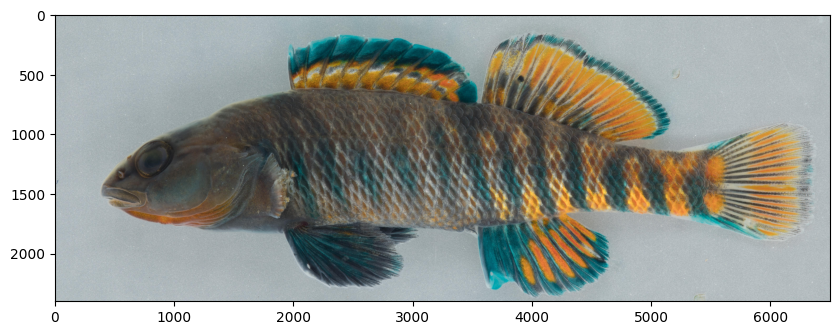

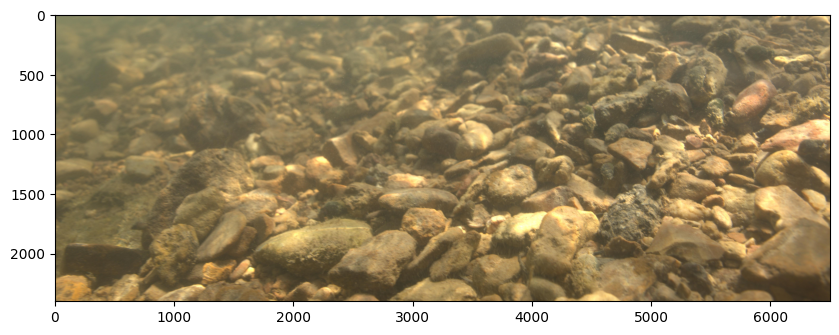

In [10]:
# Load Images
content_img = load_image(CONTENT_PATH)
style_img = load_image(STYLE_PATH)

# Show Images
show(content_img)
show(style_img)

# Load the VGG model and weights

In [11]:
# Load VGG19 Skeleton
vgg = models.vgg19(pretrained=False)

# Load pretrained weights
vgg.load_state_dict(torch.load(VGG19_PATH), strict=False)

# Change Pooling Layer
def pool_(model, pool='avg'):
    if (pool=='avg'):
        ct=0
        for layer in model.children():
            if isinstance(layer, nn.MaxPool2d):
                model[ct] = nn.AvgPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=False)
            ct+=1
    elif (pool=='max'):
        ct=0
        for layer in model.children():
            if isinstance(layer, nn.AvgPool2d):
                model[ct] = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
            ct+=1

    return model

#vgg.features = pool_(vgg.features, POOL)

# Extract only the 'features' network,
# 'classifier' network is not needed
model = copy.deepcopy(vgg.features)
model.to(device)

# Turn-off unnecessary gradient tracking
for param in model.parameters():
    param.requires_grad = False

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


# Define the loss functions

In [12]:
"""
Loss Functions
All loss functions are basically Mean of the Squared Errors (MSE)
g - generated features
c - content features
s - style features

1. OPTIONAL What is Total Variation(TV) Loss ???
    The total variation (TV) loss encourages spatial smoothness in the generated image.
   It was not used by Gatys et al in their CVPR paper but it can sometimes improve the
   results; for more details and explanation see Mahendran and Vedaldi
   "Understanding Deep Image Representations by Inverting Them" CVPR 2015.

   - @jcjohnson
   https://github.com/jcjohnson/neural-style/issues/302

2. How to implement TV Loss?
    https://en.wikipedia.org/wiki/Total_variation_denoising
"""
mse_loss = torch.nn.MSELoss()
def gram(tensor):
    B, C, H, W = tensor.shape
    x = tensor.view(C, H*W)
    return torch.mm(x, x.t())

def content_loss(g, c):
    loss = mse_loss(g, c)
    return loss

def style_loss(g, s):
    c1,c2 = g.shape
    loss = mse_loss(g, s)
    return loss / (c1**2) # Divide by square of channels

def tv_loss(c):
    x = c[:,:,1:,:] - c[:,:,:-1,:]
    y = c[:,:,:,1:] - c[:,:,:,:-1]
    loss = torch.sum(torch.abs(x)) + torch.sum(torch.abs(y))
    return loss

#Define the forward pass where features are extracted

In [13]:
# VGG Forward Pass
def get_features(model, tensor):
    layers = {
        '3': 'relu1_2',   # Style layers
        '8': 'relu2_2',   # Style layers
        '17' : 'relu3_3', # Style layers
        '26' : 'relu4_3', # Style layers
        '35' : 'relu5_3', # Style layers
        '22' : 'relu4_2', # Content layers
        #'31' : 'relu5_2'
    }

    # Get features
    features = {}
    x = tensor
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            if (name=='22'):   # relu4_2
                features[layers[name]] = x
            elif (name=='31'): # relu5_2
                features[layers[name]] = x
            else:
                b, c, h, w = x.shape
                features[layers[name]] = gram(x) / (h*w)

            # Terminate forward pass
            if (name == '35'):
                break

    return features

In [14]:
# Generate Initial Image
def initial(content_tensor, init_image='random'):
    B, C, H, W = content_tensor.shape
    if (init_image=='random'):
        #tensor = torch.randn(C, H, W).mul(torch.std(content_tensor.clone().cpu())/255).unsqueeze(0)
        tensor = torch.randn(C, H, W).mul(0.001).unsqueeze(0)
    else:
        tensor = content_tensor.clone().detach()

    return tensor

# Convert Images to Tensor
content_tensor = itot(content_img).to(device)
style_tensor = itot(style_img).to(device)
g = initial(content_tensor, init_image=INIT_IMAGE)
g = g.to(device).requires_grad_(True)

#Style and content weights and layers

Here you can modify the weights that you put on the style. You can determine which layers you want to emphasize. In our case, we chose to focus on layers 1 and 2, which correspond to more local features of the image (local statistics).

In [15]:
def stylize(iteration=NUM_ITER):
    # Get features representations/Forward pass
    content_layers = ['relu4_2']
    content_weights = {'relu4_2': 1.0}
    style_layers = ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3', 'relu5_3']
    ###style_weights = {'relu1_2': 0.2, 'relu2_2': 0.2, 'relu3_3': 0.2, 'relu4_3': 0.2, 'relu5_3': 0.2} # default
    style_weights = {'relu1_2': 0.5, 'relu2_2': 0.5, 'relu3_3': 0.0, 'relu4_3': 0.0, 'relu5_3': 0.0} # ours
    c_feat = get_features(model, content_tensor)
    s_feat = get_features(model, style_tensor)

    i = [0]
    while i[0] < iteration:
        def closure():
            # Zero-out gradients
            optimizer.zero_grad()

            # Forward pass
            g_feat = get_features(model, g)

            # Compute Losses
            c_loss=0
            s_loss=0
            for j in content_layers:
                c_loss += content_weights[j] * content_loss(g_feat[j], c_feat[j])
            for j in style_layers:
                s_loss += style_weights[j] * style_loss(g_feat[j], s_feat[j])

            c_loss = CONTENT_WEIGHT * c_loss
            s_loss = STYLE_WEIGHT * s_loss
            t_loss = TV_WEIGHT * tv_loss(g.clone().detach())
            total_loss = c_loss + s_loss + t_loss
            # t_loss = 0
            # total_loss = c_loss + s_loss

            # Backprop
            total_loss.backward(retain_graph=True)

            # Print Loss, show and save image
            i[0]+=1
            if (((i[0] % SHOW_ITER) == 1) or (i[0]==NUM_ITER)):
                print("Style Loss: {} Content Loss: {} TV Loss: {} Total Loss : {}".format(s_loss.item(), c_loss.item(), t_loss, total_loss.item()))
                if (PRESERVE_COLOR=='True'):
                    g_ = transfer_color(ttoi(content_tensor.clone().detach()), ttoi(g.clone().detach()))
                else:
                    g_ = ttoi(g.clone().detach())
                show(g_)
                saveimg(g_, i[0]-1)
                plt.show()

            return (total_loss)

        # Weight/Pixel update
        optimizer.step(closure)

    return g

#Define the optimizer.
The optimizer minimizes the total loss.
This section will display the different iterations of the algorithm to create the final image.
This is the step that takes the longest. The speed of execution will depend on whether you are running the script on a gpu (cuda) or on a cpu.

Style Loss: 30662170.0 Content Loss: 0.0 TV Loss: 3267.382080078125 Total Loss : 30665438.0


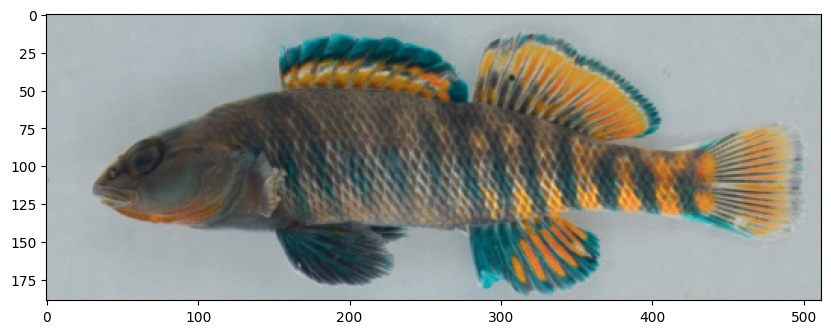

Style Loss: 9376.4150390625 Content Loss: 40749.29296875 TV Loss: 5311.05224609375 Total Loss : 55436.7578125


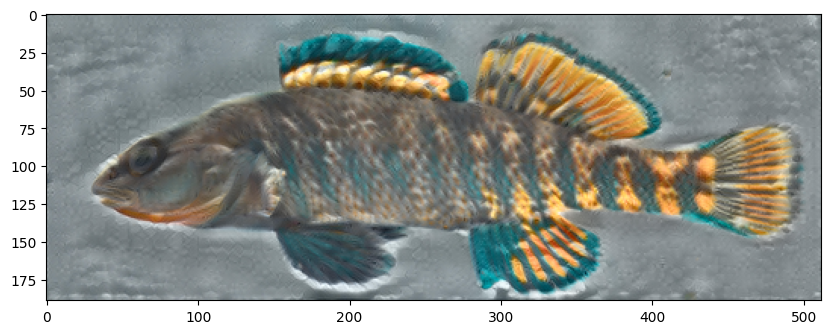

Style Loss: 8967.5 Content Loss: 36641.2578125 TV Loss: 6254.80126953125 Total Loss : 51863.55859375


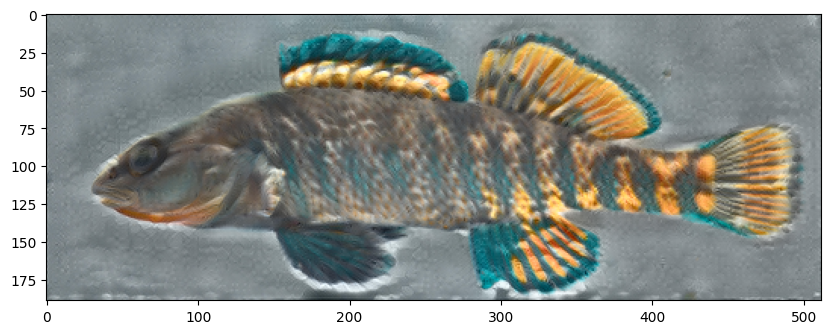

Style Loss: 8812.31640625 Content Loss: 35370.015625 TV Loss: 6955.25439453125 Total Loss : 51137.5859375


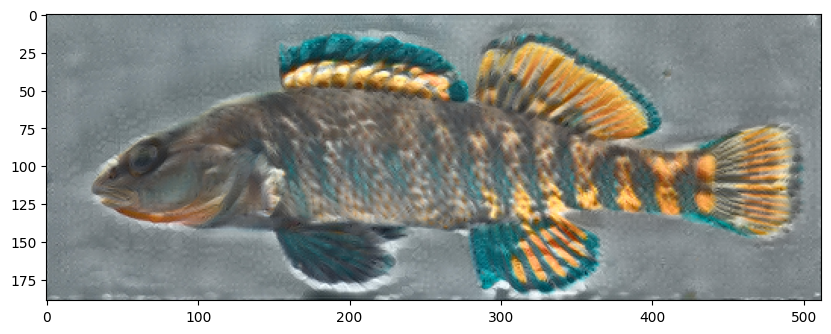

Style Loss: 8721.181640625 Content Loss: 34708.1484375 TV Loss: 7612.49169921875 Total Loss : 51041.8203125


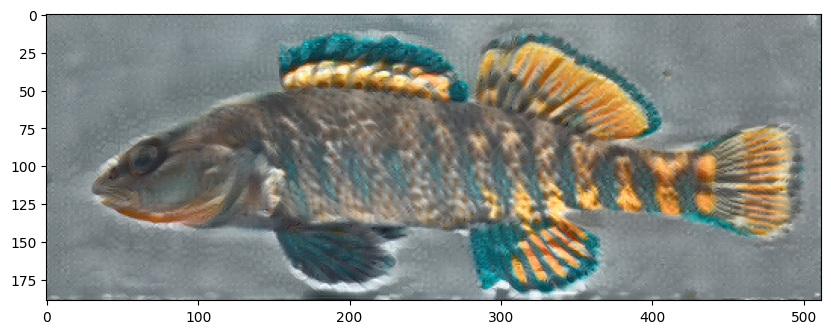

Style Loss: 8657.830078125 Content Loss: 34266.6953125 TV Loss: 8234.0087890625 Total Loss : 51158.53125


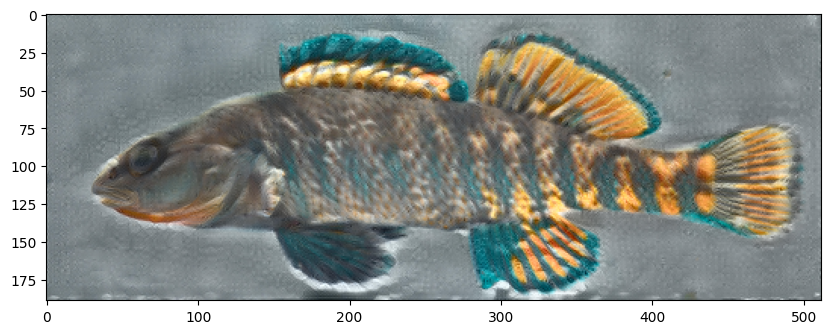

In [16]:
"""
Define Optimizer
The optimizer minimizes the total loss by updating the tensor 'g'.
"""
if (OPTIMIZER=='lbfgs'):
    optimizer = optim.LBFGS([g])
elif (OPTIMIZER=='adam'):
    optimizer = optim.Adam([g], lr=ADAM_LR)

# Stylize!
out = stylize(iteration=NUM_ITER)

#Show the output images
Three images will be shown: the original content image and the two final versions of styled images, one with the color of the content (preserve_color set to true), one with the color of the style (preserve_color set to false).

The different images will appear in your colab folder. You will want to save the ones you want to keep before re-running the code on another pair of images.

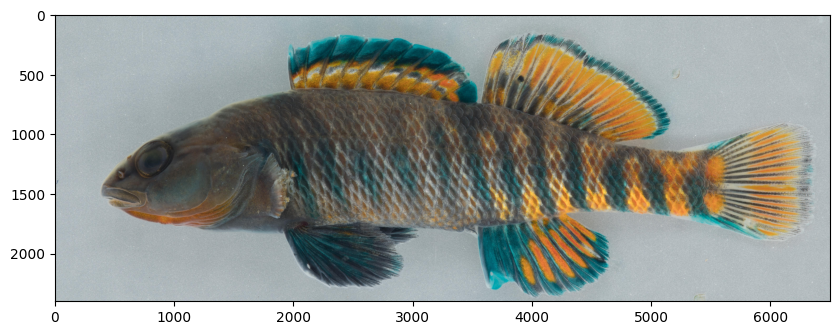

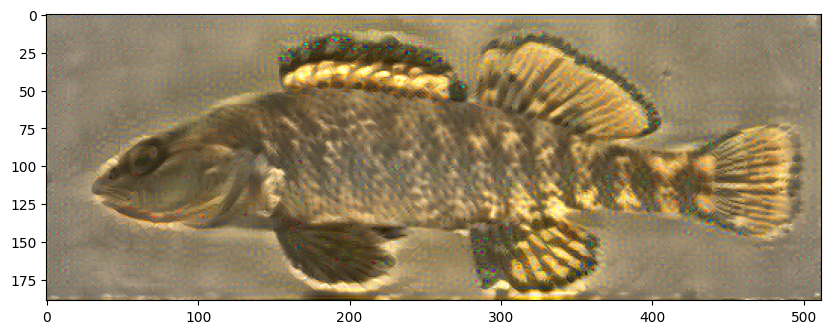

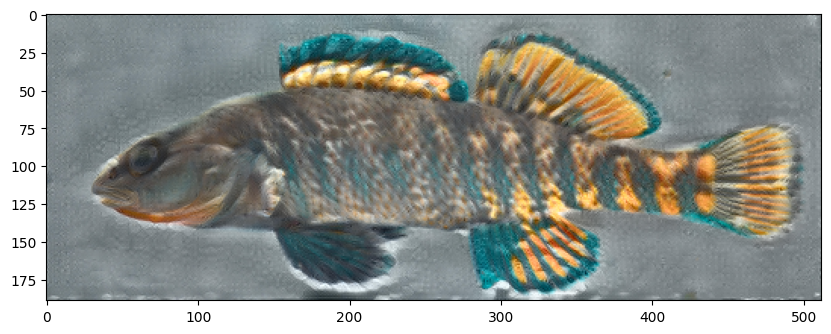

In [17]:
show(content_img) # Original Content

show(ttoi(g.clone().detach())) # Style Transfer
saveimg(ttoi(g.clone().detach()), NUM_ITER)

if (PRESERVE_COLOR=='True'):
    c_clone = ttoi(content_tensor.clone().detach())
    g_clone = ttoi(g.clone().detach())
    g_preserve = transfer_color(c_clone, g_clone) # Style Transfer + Preserve original color
    show(g_preserve)
    saveimg(g_preserve, 333)
    # out333 = final with preserved colors (ie colors of the content image)
    # final without preserving colors: out500 (ie colors of the style image)